Learning how pytorch works...

In [1]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
from torchvision.models import MobileNet_V2_Weights

import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support   
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path
from torch.utils.data import Dataset
import json # hey thats me
from PIL import Image

#### <b>Hyperparameters:<b>

In [2]:
LR_RATE = 0.001
EPOCHS = 16
BATCH_SIZE = 16
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-8
NUM_CLASSES = 8

In [3]:
# Use GPU if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def get_model():
    model = torch.hub.load('pytorch/vision:v0.16.2', 'mobilenet_v2', weights=MobileNet_V2_Weights.DEFAULT)
    model.classifier[1] = torch.nn.Linear(1280, NUM_CLASSES)
    
    return model

In [5]:
class RecyclingTrainDataset(Dataset):
    def __init__(self, setname, transform=None):
        self.setname = setname
        assert setname in ['train', 'eval', 'test']
        
        overall_dataset_dir = Path(os.getcwd()) / 'plastic_data'
        self.selected_dataset_dir = overall_dataset_dir / setname
        
        if transform:
            self.transform = transform
        else:
            self.trasnform = lambda x : x
        
        #E.g. self.all_filenames = ['006.png','007.png','008.png'] when setname=='val'
        self.all_filenames = os.listdir(self.selected_dataset_dir)
        with open(str(overall_dataset_dir / Path('labels.json')), 'r') as f:
            self.labels = json.load(f)
    
    def __len__(self):
        """Return the total number of examples in this split, e.g. if
        self.setname=='train' then return the total number of examples
        in the training set"""
        return len(self.all_filenames)
        
    def __getitem__(self, idx):
        """Return the example at index [idx]. The example is a dict with keys
        'data' (value: Tensor for an RGB image) and 'label' (value: multi-hot
        vector as Torch tensor of gr truth class labels)."""
        selected_filename = self.all_filenames[idx]
        imagepil = Image.open(os.path.join(self.selected_dataset_dir,selected_filename)).convert('RGB')
       
        # convert image to Tensor and normalize
        image = self.transform(imagepil)

        # load label --> subtract 1 to zero index labels which correlate to plastic types (1->7) and 8 = no plastic
        label = self.labels[selected_filename] - 1
        
        return image, label

In [6]:
# Convert all images to tensors and resize them accordingly
transform  = T.Compose([T.AutoAugment(), T.ToTensor(), T.Resize((200, 200))])

training_set = RecyclingTrainDataset('train', transform=transform)
validation_set = RecyclingTrainDataset('eval', transform=transform)
test_set = RecyclingTrainDataset('test', transform=transform)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

labelNumberDict = {"1_polyethylene_PET":1, "2_high_density_polyethylene_PE-HD":2, "3_polyvinylchloride_PVC":3,
          "4_low_density_polyethylene_PE-LD":4, "5_polypropylene_PP":5, "6_polystyrene_PS":6, "7_other_resins":7, 
          "8_no_plastic":8}

numberLabelDict = {0:"1_polyethylene_PET", 1:"2_high_density_polyethylene_PE-HD", 2:"3_polyvinylchloride_PVC",
          3:"4_low_density_polyethylene_PE-LD", 4:"5_polypropylene_PP", 5:"6_polystyrene_PS", 6:"7_other_resins", 
          7:"8_no_plastic"}

num_classes = len(labelNumberDict.keys())

In [244]:
# # download dataset and transform it

# transform =  T.Compose([T.ToTensor(),
#                         T.Normalize((0.5,), (0.5,))])

# training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# training_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)

# classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# num_classes = len(classes)

In [7]:
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 475 instances
Validation set has 103 instances


In [246]:
# # debug
dataiter = iter(training_loader)
images, labels = next(dataiter)

for images, labels in dataiter:
    pass

8_no_plastic  4_low_density_polyethylene_PE-LD  5_polypropylene_PP  4_low_density_polyethylene_PE-LD


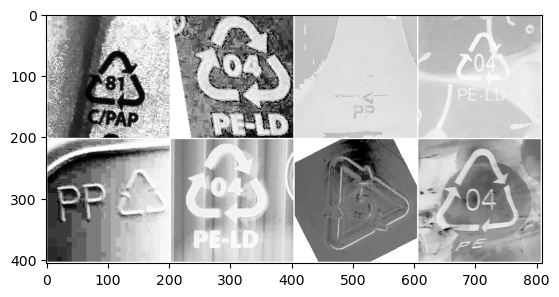

In [247]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

N_PICS = 4

dataiter = iter(training_loader)
image, labels = next(dataiter)

temp = [image]
lbls = [labels]

for i in range(4):
    image, lab = next(dataiter)
    #images = torch.cat((images, img), dim=0)
    if image.size() == torch.Size([1, 3, 200, 200]):
        if len(temp) < N_PICS:
            temp.append(image)
            lbls.append(lab)
        else:
            break


labels = torch.cat(lbls, dim=0).tolist()
images = torch.cat(temp, dim=0)
# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images, nrow=4)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(numberLabelDict[labels[j]] for j in range(4)))

In [248]:
print(torchvision.__version__)
model = torch.hub.load('pytorch/vision:v0.16.2', 'mobilenet_v2', weights=MobileNet_V2_Weights.DEFAULT)

0.16.2


Using cache found in /home/jason/.cache/torch/hub/pytorch_vision_v0.16.2


In [249]:
# Change output of classifier to be num_classes
print(model.classifier[1])

model.classifier[1] = torch.nn.Linear(1280, num_classes)

torch.nn.init.xavier_uniform_(model.classifier[1].weight)
torch.nn.init.zeros_(model.classifier[1].bias)

print(model.classifier[1])

Linear(in_features=1280, out_features=1000, bias=True)
Linear(in_features=1280, out_features=8, bias=True)


In [250]:
# print(model.features[0][0].weight.size())
# tempWeights = torch.nn.Parameter(model.features[0][0].weight[:,:1,:,:])
# print(tempWeights.size())
# model.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=(1,1), bias=False)
# model.features[0][0].weight = tempWeights

In [8]:
model = model.to('cuda')

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE, betas=[BETA1, BETA2], eps=EPSILON)

In [252]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    # training_loader = dataloader object
    # remember: 1 epoch = 1 pass through the entire dataset!
    for i, data in enumerate(training_loader):
        # extract from batch
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # compute loss & its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # adjust the weights
        optimizer.step()
        
        # add loss to cumilative loss
        running_loss += loss.item()
        
        if i % 100 == 99:
            last_loss = running_loss / 1000   # loss per batch (of 1000)
            print(f"   batch: {i+1}    loss: {last_loss}")
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        
    return last_loss

In [253]:
timestamp = datetime.now().strftime('%Y%m%d_%H_%M_%S')
writer = SummaryWriter('runs/recycling_codes_{}'.format(timestamp))
epoch_number = 0
save_path = "model_checkpoints"
if not os.path.exists(save_path):
    os.mkdir(save_path)

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    print(f"Running loss: {running_vloss}")
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), Path(save_path) / Path(model_path))

    epoch_number += 1

EPOCH 1:


Running loss: 29.385223388671875
LOSS train 0.0 valid 2.260401964187622
EPOCH 2:
Running loss: 27.24411964416504
LOSS train 0.0 valid 2.0957016944885254
EPOCH 3:
Running loss: 27.092639923095703
LOSS train 0.0 valid 2.0840492248535156
EPOCH 4:
Running loss: 28.303401947021484
LOSS train 0.0 valid 2.177184820175171
EPOCH 5:
Running loss: 25.931699752807617
LOSS train 0.0 valid 1.994746208190918
EPOCH 6:
Running loss: 22.826284408569336
LOSS train 0.0 valid 1.7558680772781372
EPOCH 7:
Running loss: 19.29515266418457
LOSS train 0.0 valid 1.484242558479309
EPOCH 8:
Running loss: 20.324975967407227
LOSS train 0.0 valid 1.5634597539901733
EPOCH 9:
Running loss: 20.865793228149414
LOSS train 0.0 valid 1.6050610542297363
EPOCH 10:
Running loss: 26.5175724029541
LOSS train 0.0 valid 2.039813280105591
EPOCH 11:
Running loss: 20.015533447265625
LOSS train 0.0 valid 1.5396565198898315
EPOCH 12:
Running loss: 18.2663516998291
LOSS train 0.0 valid 1.4051040410995483
EPOCH 13:
Running loss: 17.632907

In [7]:
# Run testing/validation:
model = get_model()
MODEL_CKPT_FOLDER = './model_checkpoints'

for path in os.listdir(MODEL_CKPT_FOLDER):
    try:
        model.load_state_dict(torch.load(Path(MODEL_CKPT_FOLDER) / Path(path)))
        model.to(device)
        
        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()
        
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(test_loader):
                vinputs, vlabels = vdata
                vinputs, vlabels = vinputs.to(device), vlabels.to(device)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss

        print(f"Evaluating {path}...")
        print(f"Validation loss: {running_vloss / (i+1)}\n")
    except Exception as e:
        print("Error")
        print(e)
        print('\n')
    

Using cache found in /home/jason/.cache/torch/hub/pytorch_vision_v0.16.2


Error
name 'loss_fn' is not defined


Error
name 'loss_fn' is not defined


Error
name 'loss_fn' is not defined


Error
Error(s) in loading state_dict for MobileNetV2:
	size mismatch for features.0.0.weight: copying a param with shape torch.Size([32, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 3, 3, 3]).
	size mismatch for classifier.1.weight: copying a param with shape torch.Size([10, 1280]) from checkpoint, the shape in current model is torch.Size([8, 1280]).
	size mismatch for classifier.1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([8]).


Error
name 'loss_fn' is not defined


Error
name 'loss_fn' is not defined


Error
name 'loss_fn' is not defined


Error
name 'loss_fn' is not defined


Error
name 'loss_fn' is not defined


Error
name 'loss_fn' is not defined


Error
name 'loss_fn' is not defined


Error
name 'loss_fn' is not defined


Error
name 'loss_fn' is not defined


Error
name 'los

In [9]:
selected_models = ["model_20231228_18_37_07_1", "model_20231228_18_30_20_4", "model_20231228_18_23_15_13"]

In [10]:
# load checkpoint models and conver them to file type .mlmodel
import coremltools as ct

OUTPUT_FOLDER = "./mlmodels"

if os.path.isdir(OUTPUT_FOLDER):
    os.mkdir(OUTPUT_FOLDER)

model = get_model()

for model_path in selected_models:
    model.load_state_dict(torch.load(Path(MODEL_CKPT_FOLDER) / Path(model_path)))
    # Set the model in evaluation mode.
    model.eval()

    # Trace the model with random data.
    example_input = torch.rand(1, 3, 224, 224) 
    traced_model = torch.jit.trace(model, example_input)
    out = traced_model(example_input)

    mlModel = ct.convert(
        traced_model,
        inputs=[ct.TensorType(shape=example_input.shape)]
    )
    
    mlModel.save(Path(OUTPUT_FOLDER) / Path(model_path + ".mlpackage"))

Torch version 2.1.2 has not been tested with coremltools. You may run into unexpected errors. Torch 2.1.0 is the most recent version that has been tested.


Using cache found in /home/jason/.cache/torch/hub/pytorch_vision_v0.16.2
When both 'convert_to' and 'minimum_deployment_target' not specified, 'convert_to' is set to "mlprogram" and 'minimum_deployment_targer' is set to ct.target.iOS15 (which is same as ct.target.macOS12). Note: the model will not run on systems older than iOS15/macOS12/watchOS8/tvOS15. In order to make your model run on older system, please set the 'minimum_deployment_target' to iOS14/iOS13. Details please see the link: https://coremltools.readme.io/docs/unified-conversion-api#target-conversion-formats
Running MIL default pipeline:   0%|          | 0/71 [00:00<?, ? passes/s]/home/jason/miniconda3/envs/ResearchEnv/lib/python3.10/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:239: UserWarning: Input, 'x.1', of the source model, has been renamed to 'x_1' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00

Exception: For an ML Program, extension must be .mlpackage (not .mlmodel). Please see https://coremltools.readme.io/docs/unified-conversion-api#target-conversion-formats to see the difference between neuralnetwork and mlprogram model types.